## Time Series Final Project

In [634]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [635]:
# import data
data = pd.read_csv("temperature.csv",usecols = ["datetime","Chicago"],index_col='datetime',
                   parse_dates=['datetime'],low_memory=False)



In [301]:
data

,Chicago
datetime,
2012-10-01 12:00:00,nan
2012-10-01 13:00:00,284.01000000
2012-10-01 14:00:00,284.05469097
2012-10-01 15:00:00,284.17741218
2012-10-01 16:00:00,284.30013339
...,...
2017-11-29 20:00:00,281.34000000
2017-11-29 21:00:00,281.69000000
2017-11-29 22:00:00,281.07000000


In [636]:
df = pd.read_csv("temperature.csv")
df.datetime = pd.to_datetime(df.datetime).dt.date
df_chi = df.loc[:, ["datetime", "Chicago"]]
data = df_chi.groupby('datetime').mean()
data

,Chicago
datetime,
2012-10-01,284.55266947
2012-10-02,287.71351138
2012-10-03,289.12791667
2012-10-04,290.03250000
2012-10-05,291.20750000
...,...
2017-11-26,275.98083333
2017-11-27,279.12833333
2017-11-28,285.73083333


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1887 entries, 2012-10-01 to 2017-11-30
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Chicago  1887 non-null   float64
dtypes: float64(1)
memory usage: 29.5+ KB


In [22]:
#Check for null values
data.isnull().sum()

Chicago    0
dtype: int64

In [555]:
#convert temperature from Kelvin to Fahrenheit
#Fahrenheit = 1.8 * Celsius + 32

#Kelvin = 273.15 + Celsius

data["Chicago"]=((data["Chicago"])-(273.15))*1.8+32

In [558]:
data

,Chicago
datetime,
2012-10-01,52.52480504
2012-10-02,58.21432048
2012-10-03,60.76025000
2012-10-04,62.38850000
2012-10-05,64.50350000
...,...
2017-11-26,37.09550000
2017-11-27,42.76100000
2017-11-28,54.64550000


In [637]:
# Take the log difference to make data stationary
data['Chicago'] = np.log(data['Chicago'])
np.exp(data["Chicago"])

datetime
2012-10-01   284.55266947
2012-10-02   287.71351138
2012-10-03   289.12791667
2012-10-04   290.03250000
2012-10-05   291.20750000
                 ...     
2017-11-26   275.98083333
2017-11-27   279.12833333
2017-11-28   285.73083333
2017-11-29   279.47958333
2017-11-30   278.46000000
Name: Chicago, Length: 1887, dtype: float64

In [638]:
data['Chicago'] = data['Chicago'].diff()
#data = data.drop(data.index[0])

In [639]:
data.dropna(inplace=True) # due to shifting there is nan values

In [598]:
data

,Chicago
datetime,
2012-10-02,0.01104687
2012-10-03,0.00490398
2012-10-04,0.00312378
2012-10-05,0.00404309
2012-10-06,-0.03032950
...,...
2017-11-26,-0.02307423
2017-11-27,0.01134023
2017-11-28,0.02337857


In [561]:
df_transformed = data.copy()
df_transformed['Chicago'] = np.log(df_transformed['Chicago'])
df_transformed['Chicago'] = df_transformed['Chicago'].diff()
df_transformed.dropna(inplace=True) # due to shifting there is nan values

# %%
df_transformed = df_transformed.append(np.log(df_daily.iloc[0]))
df_transformed.sort_index(inplace=True)
# %%
df_transformed["Chicago"] = df_transformed["Chicago"].cumsum()
# %%
df_transformed["Chicago"] = np.exp(df_transformed["Chicago"])

# %%
df_transformed

,Chicago
datetime,
2012-10-01,284.55266947
2012-10-02,287.71351138
2012-10-03,289.12791667
2012-10-04,290.03250000
2012-10-05,291.20750000
...,...
2017-11-26,275.98083333
2017-11-27,279.12833333
2017-11-28,285.73083333


### Train/test split the data

In [640]:
train=data.iloc[:-5]
test=data.iloc[-5:]

#train = data.loc['2012-10-01':'2016-12-01']
#test=data.loc['2016-12-01':'2017-11-30']
#train = data[:int(0.95*(len(data)))]
#test = data[int(0.95*(len(data))):]

#train=chicagosample[0:77*24]
#test=chicagosample[77*24:]

In [629]:
test

,Chicago
datetime,
2016-12-01,276.41458333
2016-12-02,276.38931729
2016-12-03,274.47125000
2016-12-04,273.10098362
2016-12-05,273.65983738
...,...
2017-11-26,275.98083333
2017-11-27,279.12833333
2017-11-28,285.73083333


In [26]:
# Plot the daily temperature change 
def plot_ts(data,column,title):
    plt.figure(figsize=(16,10), dpi=100)
    plt.plot(data.index, column, color='tab:red')
    plt.gca().set(title=title, xlabel='Date', ylabel="Degrees (in Fahrenheit)")
    plt.show()

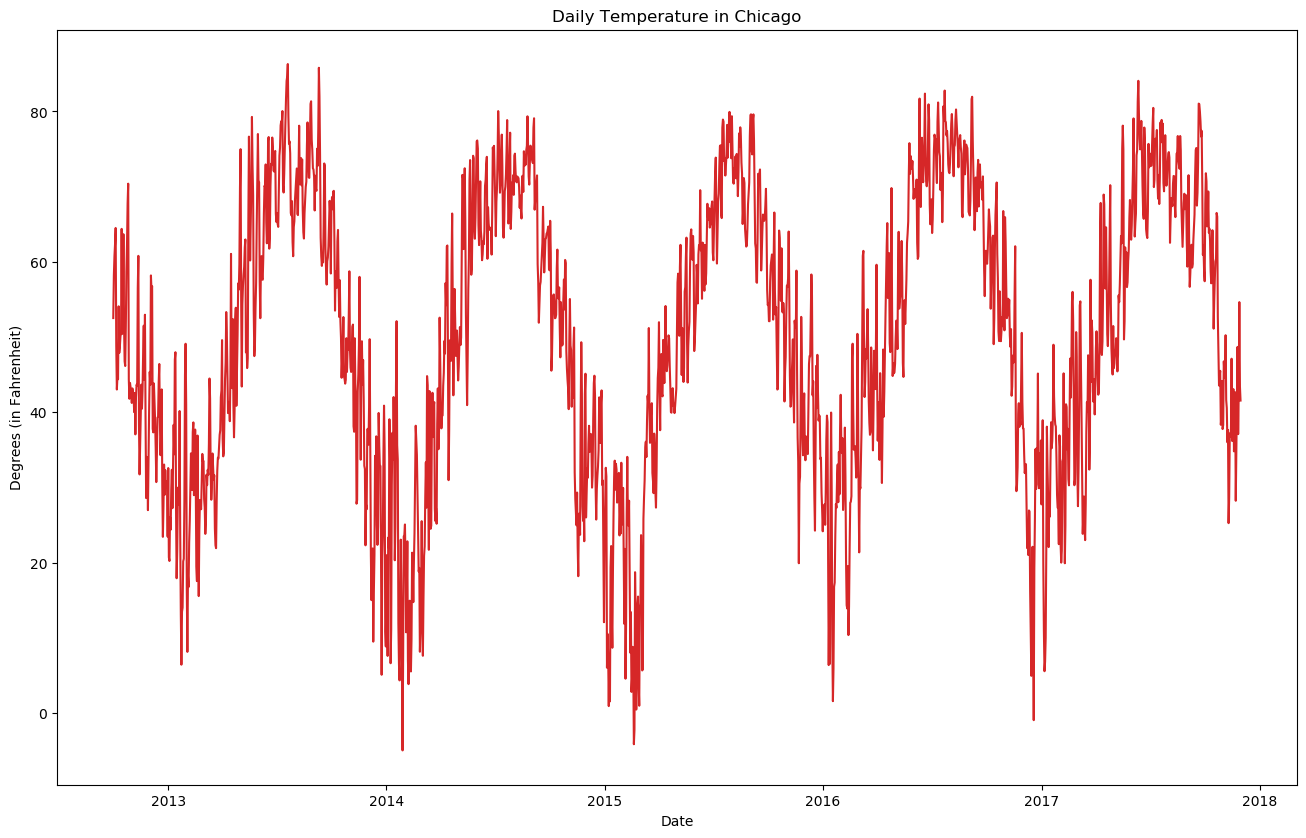

In [27]:
plot_ts(data,data["Chicago"],title="Daily Temperature in Chicago")

#### The time-series plot sshows seasonality pattern, such as temperatures are always low at the end and beginning of the year and high at the middle of the year.

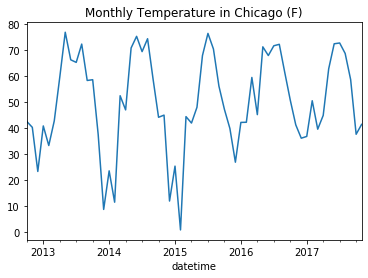

In [28]:
#plot data in monthly frequency
data["Chicago"].asfreq('M').plot() # asfreq method is used to convert a time series to a specified frequency
plt.title('Monthly Temperature in Chicago (F)')
plt.show()

#### A bit easier to visualize here, but same thing is seen in the data

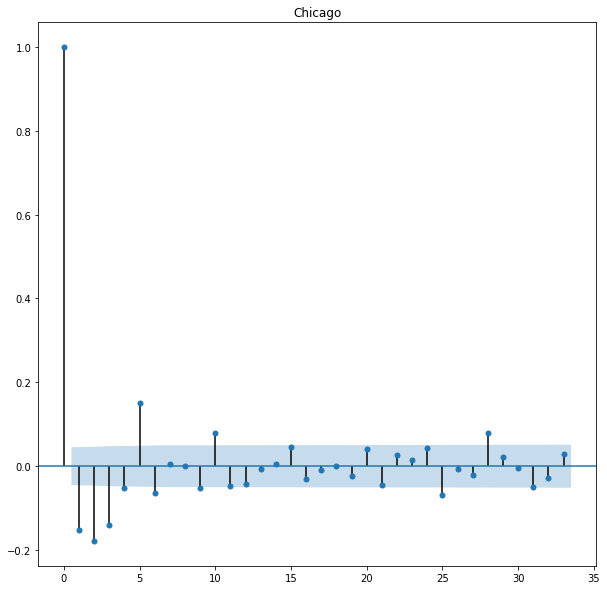

In [525]:
#plot acf
plot_acf(train,title="Chicago")
plt.show()

For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. Also, for non-stationary data, the value of  r1 is often large and positive. Our acf shows non stationary data

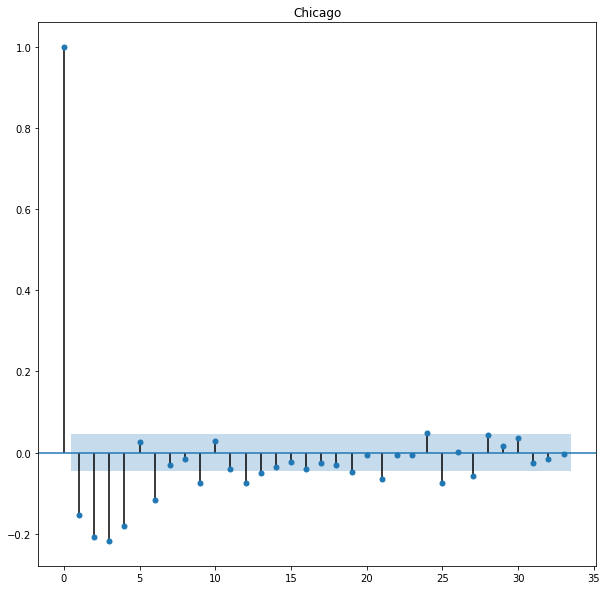

In [526]:
# Partial Autocorrelation
plot_pacf(train,title="Chicago")
plt.show()

The plot above shows the seasonality component and that the temperature is unstable.

In [229]:
#Check for Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=6).mean() 
    rolstd = pd.Series(timeseries).rolling(window=6).std()
    
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()

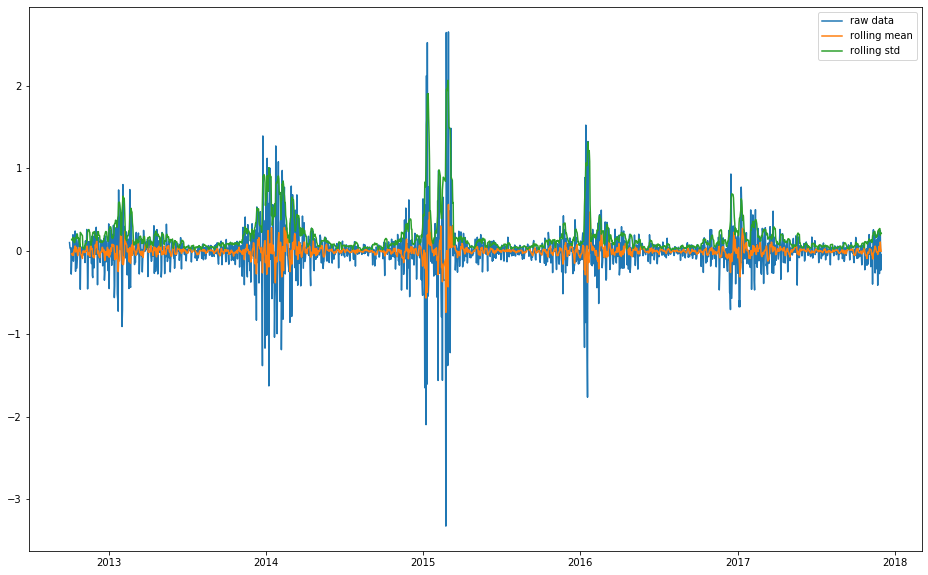

In [231]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(data["Chicago"],'raw data')

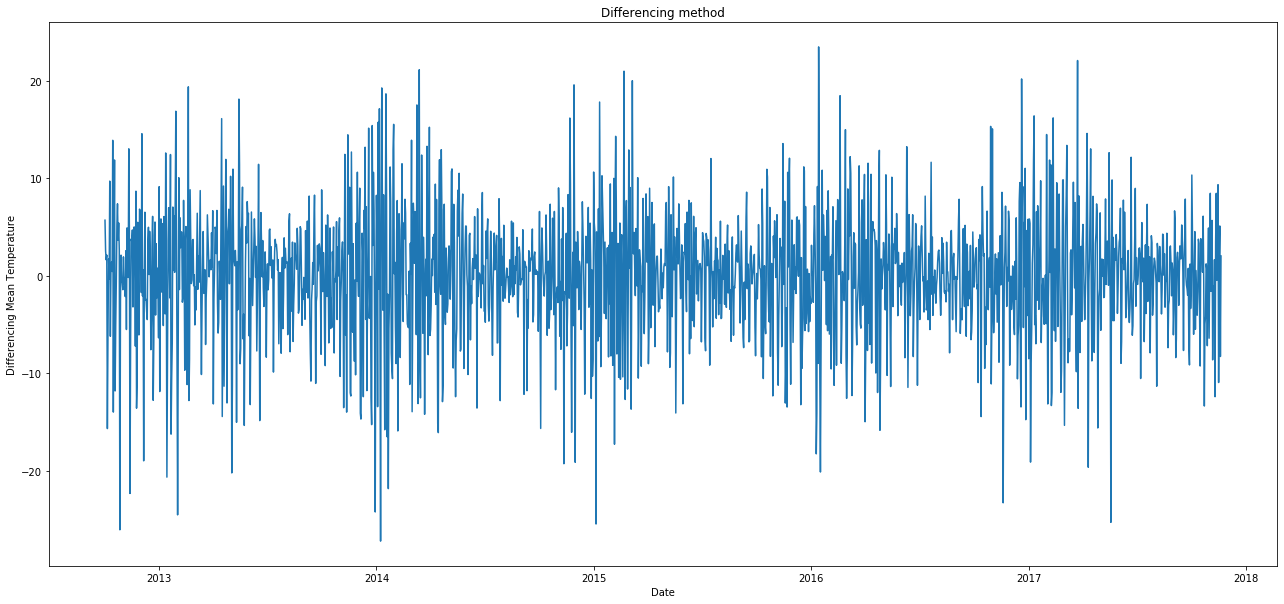

In [236]:
# differencing method
ts_diff = train - train.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

In [237]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values

In [35]:
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(window=6).mean()
    rolstd = ts.rolling(window=6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

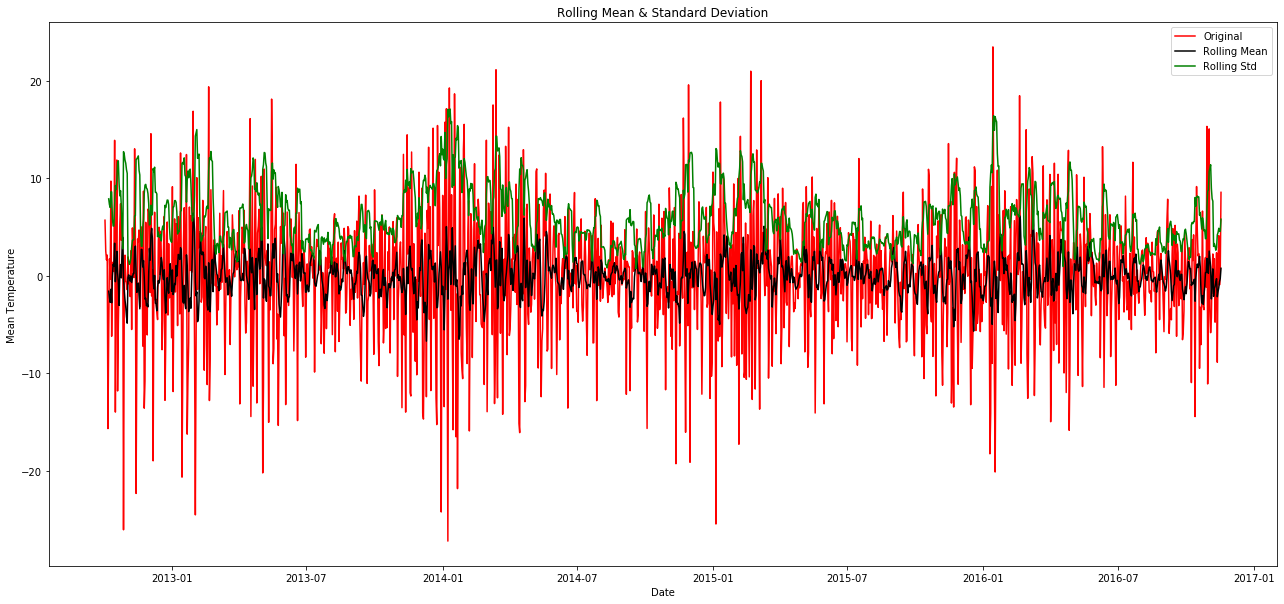

In [36]:
check_mean_std(ts_diff)

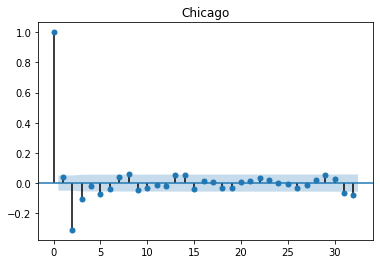

In [38]:
#plot acf
plot_acf(ts_diff,title="Chicago")
plt.show()

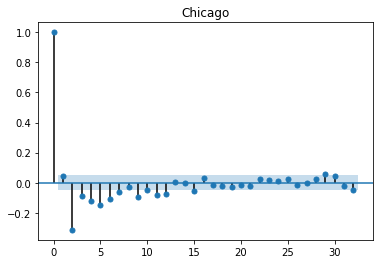

In [39]:
#plot pacf
plot_pacf(ts_diff,title="Chicago")
plt.show()

#### To confirm, we will conduct the Augmented Dickey-Fuller Test

In [167]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -17.773611973641554
p-value: 3.2995409650223225e-30
Critical Values:
	1%: -3.4304946925998454
	5%: -2.861603951007775
	10%: -2.566804039032461


If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is less than any of the critical values. Clearly, there a reason to reject the null hypothesis. So, the time series is in fact stationary.

### Modeling

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

ARIMA has three components – AR (autoregressive term), I (differencing term) and MA (moving average term). Let us understand each of these components –

AR term refers to the past values used for forecasting the next value. The AR term is defined by the parameter ‘p’ in arima. The value of ‘p’ is determined using the PACF plot.
MA term is used to defines number of past forecast errors used to predict the future values. The parameter ‘q’ in arima represents the MA term. ACF plot is used to identify the correct ‘q’ value.
Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary. Test like ADF and KPSS can be used to determine whether the series is stationary and help in identifying the d value.

                               SARIMAX Results                                
Dep. Variable:                Chicago   No. Observations:                 1874
Model:                 ARIMA(2, 0, 5)   Log Likelihood                -130.134
Date:                Mon, 06 Dec 2021   AIC                            278.268
Time:                        14:20:58   BIC                            328.091
Sample:                             0   HQIC                           296.622
                               - 1874                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.492      0.622      -0.006       0.004
ar.L1         -1.3094      0.067    -19.564      0.000      -1.441      -1.178
ar.L2         -0.7079      0.054    -13.163      0.0

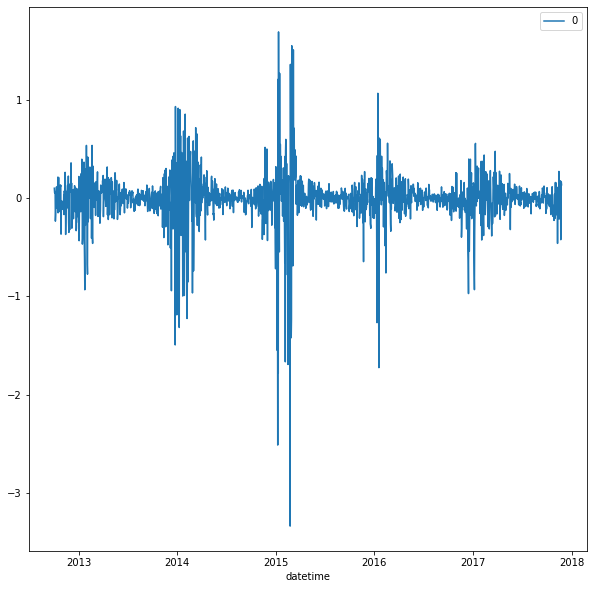

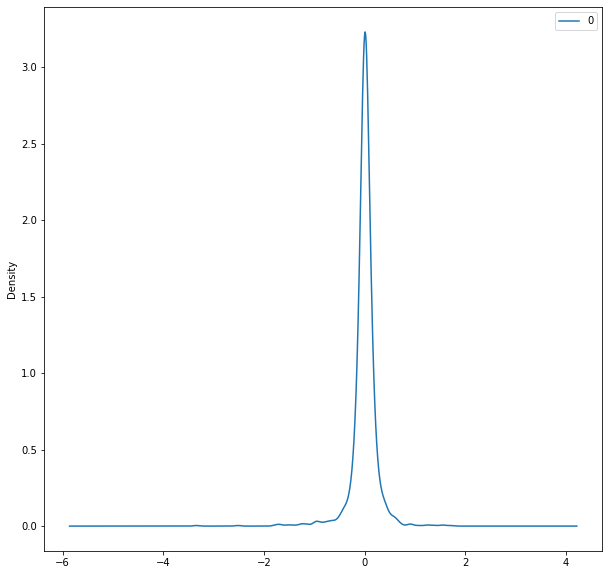

                  0
count 1874.00000000
mean     0.00023056
std      0.25940231
min     -3.34234916
25%     -0.06160059
50%      0.01032701
75%      0.08386607
max      1.69881555


In [539]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot

model = ARIMA(train, order=(2,0,5))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

### Auto Arima

In [646]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True,seasonal=False, error_action='ignore', suppress_warnings=True)

model.summary()
model_fit = model.fit(train)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11367.269, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11059.342, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11060.753, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11065.582, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11366.315, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-11349.598, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-11364.284, Time=1.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11366.301, Time=1.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11224.310, Time=0.51 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11367.046, Time=0.91 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-11257.159, Time=0.31 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-11361.903, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11361.742, Time=1.94 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 7.781 seco

In [644]:
model = ARIMA(train, order=(2,0,5))
model_fit = model.fit()

In [650]:
forecast = model_fit.predict(n_periods=len(test),dynamic=True)

ConversionError: Failed to convert value(s) to axis units: array([datetime.date(2017, 11, 26), datetime.date(2017, 11, 27),
       datetime.date(2017, 11, 28), datetime.date(2017, 11, 29),
       datetime.date(2017, 11, 30), 0, 1, 2, 3, 4], dtype=object)

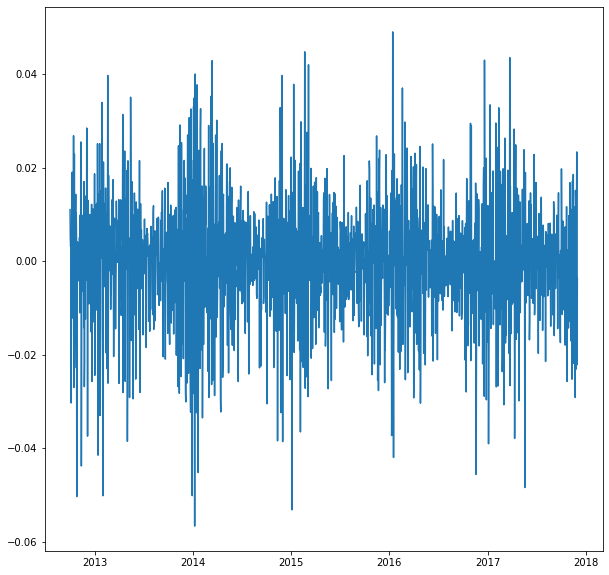

In [652]:
predictions_ARIMA_diff = pd.Series(forecast, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(test['Chicago'].iloc[0], index=test.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)

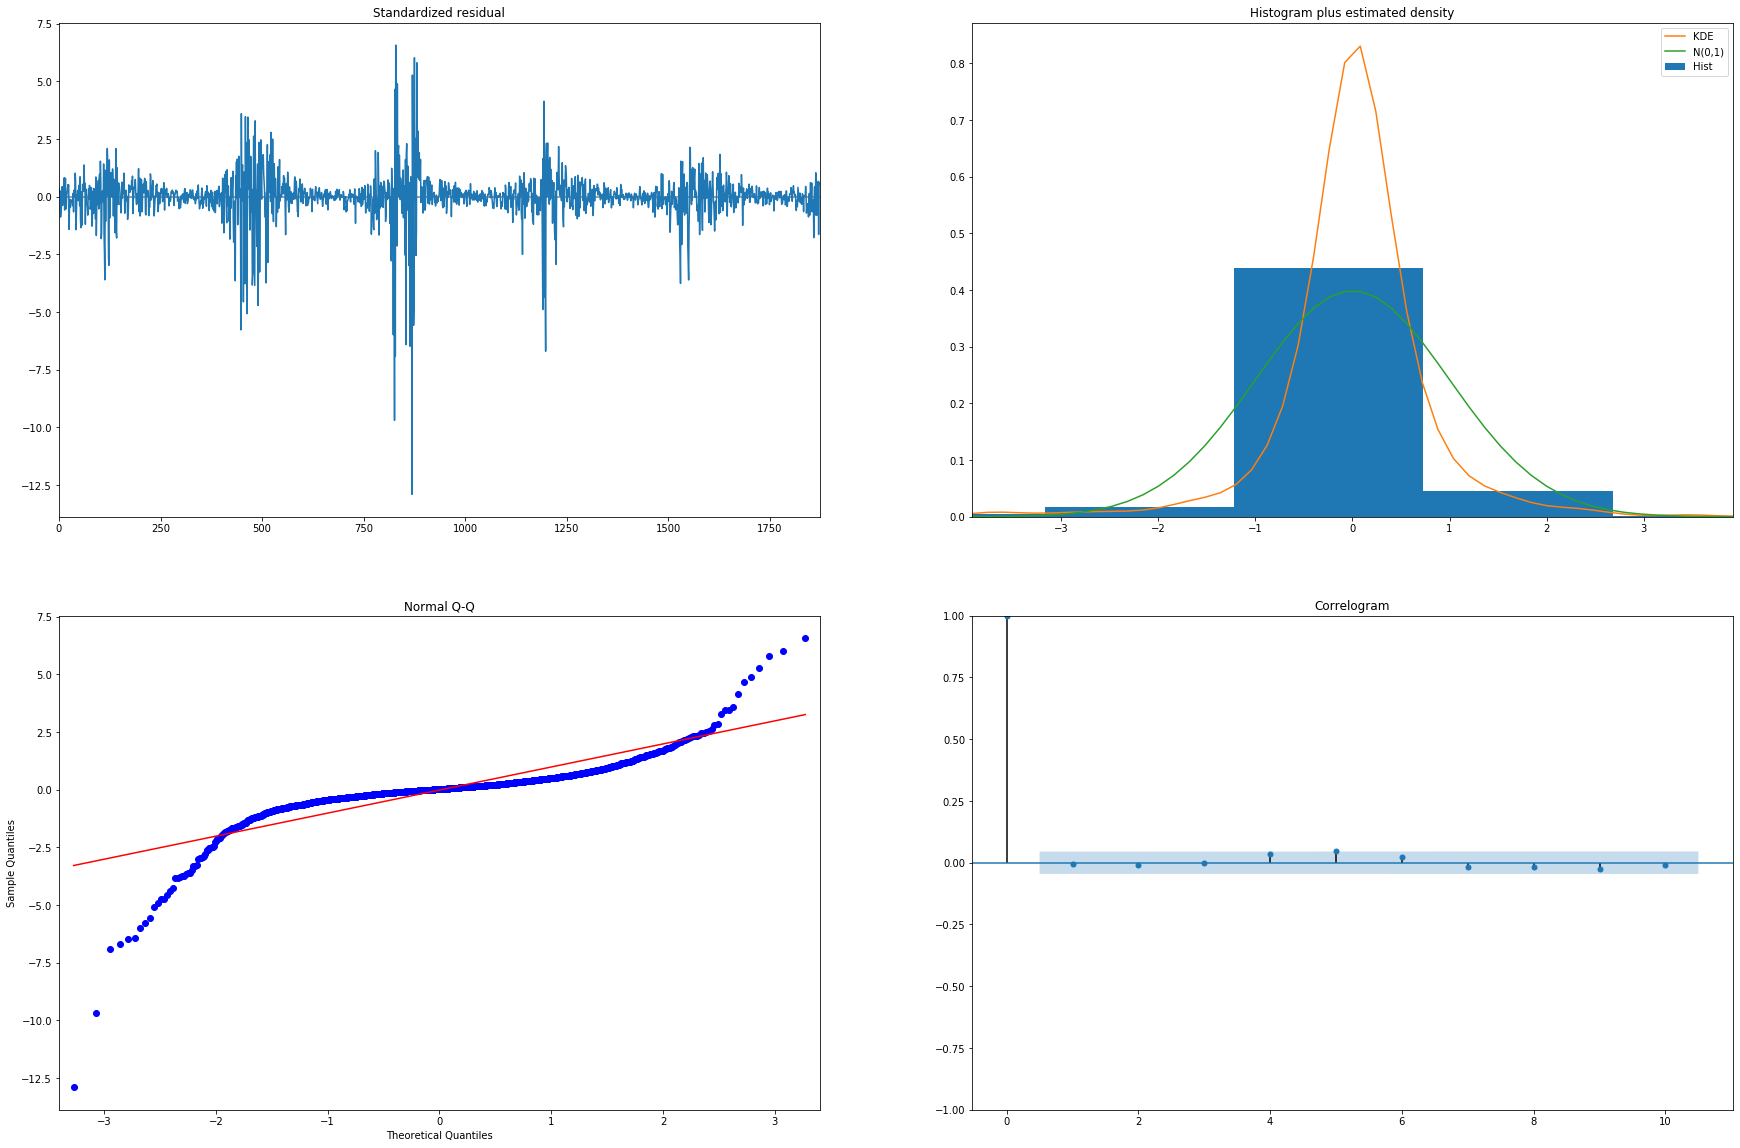

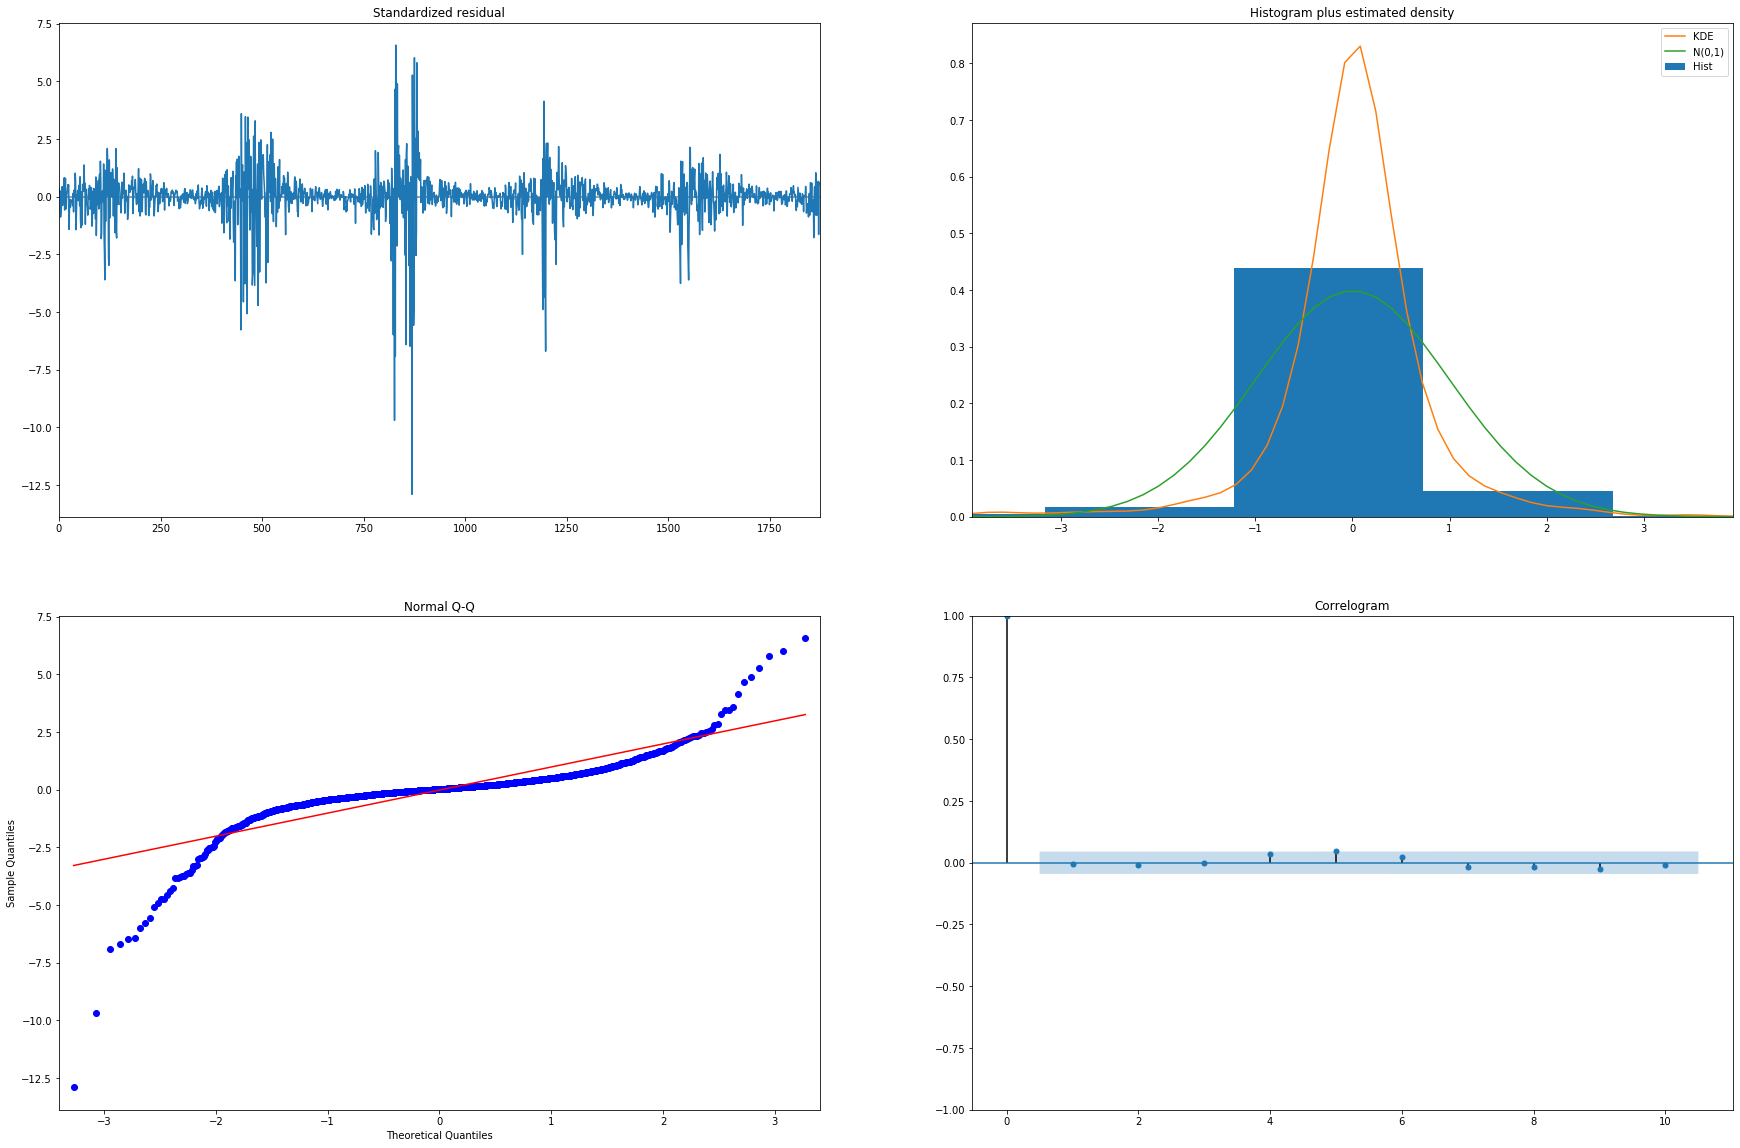

In [537]:
from matplotlib.pyplot import figure

model_fit.plot_diagnostics(figsize=(30, 20))

In [538]:
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1874
Model:               SARIMAX(2, 0, 5)   Log Likelihood                -130.158
Date:                Mon, 06 Dec 2021   AIC                            276.315
Time:                        14:20:34   BIC                            320.602
Sample:                             0   HQIC                           292.630
                               - 1874                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3586      0.056    -24.384      0.000      -1.468      -1.249
ar.L2         -0.7596      0.045    -16.982      0.000      -0.847      -0.672
ma.L1          1.0924      0.057     19.298      0.0

ValueError: DataFrame constructor not properly called!

In [540]:
residuals.mean()

0   0.00023056
dtype: float64

In [631]:
import plotly
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=False)
forecast = model_fit.predict(n_periods=len(test),dynamic=True)
future_forecast = pd.DataFrame(forecast,index = test.index,columns=['Predictions'])

pd.concat([test,future_forecast],axis=1).iplot()

In [604]:
df_transformed = test.copy()
# %%
df_transformed = df_transformed.append(np.log(df_daily.iloc[0]))
df_transformed.sort_index(inplace=True)
# %%
df_transformed["Chicago"] = df_transformed["Chicago"].cumsum()
# %%
df_transformed["Chicago"] = np.exp(df_transformed["Chicago"])

# %%
df_transformed

,Chicago
datetime,
2012-10-01,284.55266947
2017-11-26,278.06200635
2017-11-27,281.23324166
2017-11-28,287.88553115
2017-11-29,281.58714044
2017-11-30,280.55986843


In [608]:
df_transformed = future_forecast.copy()
# %%
df_transformed = df_transformed.append(test.iloc[-1])
df_transformed.sort_index(inplace=True)
# %%
df_transformed["Chicago"] = df_transformed["Predictions"].cumsum()
# %%
df_transformed["Chicago"] = np.exp(df_transformed["Predictions"])

# %%
df_transformed

,Predictions,Chicago
datetime,,
2017-11-26,-0.00336793,0.99663774
2017-11-27,-0.00729701,0.99272955
2017-11-28,-0.00309060,0.99691417
2017-11-29,-0.00097649,0.99902399
2017-11-30,-0.00026406,0.99973598
2017-11-30,nan,nan


In [520]:
model2=ARIMA(train,order=(2,0,5))
model2=model2.fit()
index_future_dates=pd.date_range(start='2017-12-30',end='2018-01-29')
#print(index_future_dates)
pred=model2.predict(start=len(train),end=len(train)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2017-12-30   -0.09074458
2017-12-31   -0.11696134
2018-01-01    0.03128028
2018-01-02   -0.04225479
2018-01-03    0.01365273
2018-01-04    0.00991258
2018-01-05   -0.02754355
2018-01-06    0.02627953
2018-01-07   -0.01846761
2018-01-08    0.00147195
2018-01-09    0.00838793
2018-01-10   -0.01619881
2018-01-11    0.01199992
2018-01-12   -0.00766694
2018-01-13   -0.00236049
2018-01-14    0.00538432
2018-01-15   -0.00919444
2018-01-16    0.00475295
2018-01-17   -0.00313444
2018-01-18   -0.00301407
2018-01-19    0.00282452
2018-01-20   -0.00521324
2018-01-21    0.00128269
2018-01-22   -0.00144125
2018-01-23   -0.00267753
2018-01-24    0.00107797
2018-01-25   -0.00309234
2018-01-26   -0.00027465
2018-01-27   -0.00093579
2018-01-28   -0.00218030
2018-01-29    0.00001658
Freq: D, Name: ARIMA Predictions, dtype: float64


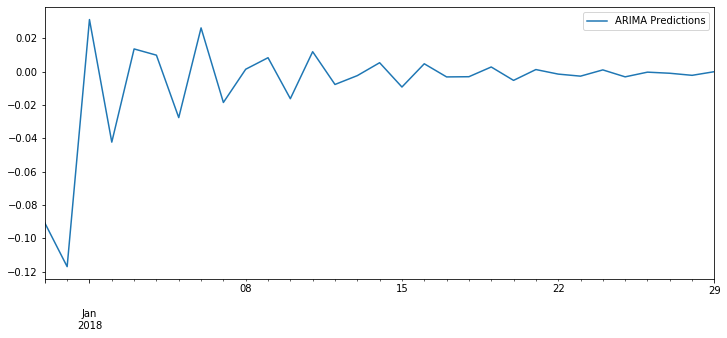

In [521]:
pred.plot(figsize=(12,5),legend=True)

In [632]:
from sklearn.metrics import mean_squared_error as MSE
# Compute the mean square error
mse = MSE(test, future_forecast, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 135.29


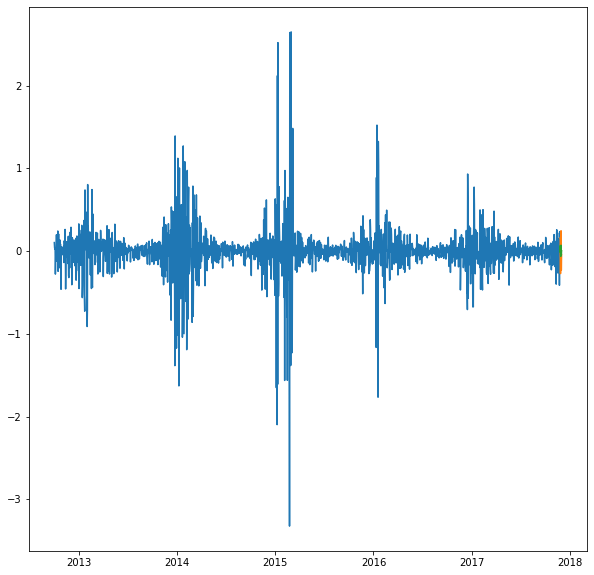

In [352]:
#autp arima plot
forecast = model.predict(n_periods=len(test),dynamic=False)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(test, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [452]:
from pandas import datetime
start_index = datetime(2017, 11, 26, 0, 0, 0)
end_index = datetime(2017, 11, 30, 0, 0, 0)



forecast = model_fit.predict(start_index,end_index,typ='levels',dynamic=True)


# In[21]:


plt.figure(figsize=(16,10))
#plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(forecast,label="Predicted")
plt.legend(loc = 'Left corner')
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [126]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train,order=(1,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Chicago   No. Observations:                 1856
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5922.064
Method:                       css-mle   S.D. of innovations              5.881
Date:                Mon, 06 Dec 2021   AIC                          11854.127
Time:                        02:52:51   BIC                          11881.758
Sample:                    10-02-2012   HQIC                         11864.311
                         - 10-31-2017                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0043      0.045     -0.098      0.922      -0.092       0.083
ar.L1.D.Chicago     0.3960      0.039     10.150      0.000       0.320       0.472
ma.L1.D.Chicago    -0.4308      0.037    -11.710      0.000      -0.503      -0.359
ma.L2.D.Chicago    -0.3726      0.024    -15.325      0.000      -0.420      -0.325
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5254           +0.0000j            2.5254            0.0000
MA.1            1.1591           +0.0000j            1.1591            0.0000
MA.2           -2.3153           +0.0000j            2.3153            0.5000
-----------------------------------------------------------------------------
"""

In [376]:
test

,Chicago
datetime,
2017-11-24,0.15726341
2017-11-25,0.15351251
2017-11-26,-0.27200367
2017-11-27,0.14213080
2017-11-28,0.24524040
2017-11-29,-0.23056297
2017-11-30,-0.04321386


In [382]:
pred.reset_index(drop=True)

0    0.03668601
1    0.01870815
2   -0.04342597
3   -0.00068425
4    0.00886209
5   -0.02712720
6    0.02643956
dtype: float64

In [388]:
test.index

Index([2017-11-24, 2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29,
       2017-11-30],
      dtype='object', name='datetime')

In [393]:
#pred=model_fit.predict(start=start,end=end,typ='levels')
forecast = pd.Series(pred.to_numpy(),index = test.index)
forecast

datetime
2017-11-24    0.03668601
2017-11-25    0.01870815
2017-11-26   -0.04342597
2017-11-27   -0.00068425
2017-11-28    0.00886209
2017-11-29   -0.02712720
2017-11-30    0.02643956
dtype: float64